## This notebook is directly inspired from Unet starter notebook by Paul Dnt(https://www.kaggle.com/pednt9) .The Goal of this notebook is to build a simple Unet baseline model using Keras 

Cf. https://arxiv.org/pdf/1505.04597.pdf

Inspired from https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [1]:
!python --version

Python 3.7.6


In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.measure import label, regionprops
from PIL import Image, ImageDraw
from ast import literal_eval
from tqdm.notebook import tqdm

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.ops.image_ops_impl import ssim_multiscale as tf_ssim_multiscale
from tensorflow.python.keras.losses import huber_loss as huber_loss_keras

import keras
from sklearn.model_selection import train_test_split
import imageio
import cv2 



Using TensorFlow backend.


Credits: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu/

## Use TPU, optimal

In [3]:
# # Detect hardware, return appropriate distribution strategy
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

# print("REPLICAS: ", strategy.num_replicas_in_sync)

## GPU SETTINGS

In [7]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)


## SETTINGS

In [8]:
# Set some parameters
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
BATCH_SIZE = 1
EPOCHS = 25

#multi processing setting for model
max_queue_size=4 
workers=4 
use_multiprocessing=False

TRAIN_PATH = '/kaggle/input/global-wheat-detection/train/'
TEST_PATH = '/kaggle/input/global-wheat-detection/test/'
SC_FACTOR = int(1024 / IMG_WIDTH)

warnings.filterwarnings('ignore')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [9]:
PATH = "../input/global-wheat-detection/"
train_folder = os.path.join(PATH, "train")
test_folder = os.path.join(PATH, "test")

train_csv_path = os.path.join(PATH, "train.csv")
df = pd.read_csv(train_csv_path)
sample_sub = pd.read_csv(PATH + "sample_submission.csv")

df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [ ]:
df.shape

In [10]:
# Get train and test IDs and paths
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

# train_ids = train_ids[0:50]

In [ ]:
train_ids[:5]

In [11]:
def append_path(path):
    return np.vectorize(lambda file: os.path.join(path, file))

train_paths = append_path('/kaggle/input/global-wheat-detection/train')(train_ids[:])
test_paths = append_path('/kaggle/input/global-wheat-detection/test')(test_ids[:])

In [ ]:
train_paths

## Produce the labels, once done, no moer needed

In [12]:
def make_polygon(coords):
    xm, ym, w, h = coords
    xm, ym, w, h = xm / SC_FACTOR, ym / SC_FACTOR, w / SC_FACTOR, h / SC_FACTOR   # scale values if image was downsized
    return [(xm, ym), (xm, ym + h), (xm + w, ym + h), (xm + w, ym)]

# masks = dict() # dictionnary containing all masks

# for img_id, gp in tqdm(df.groupby("image_id")):
#     gp['polygons'] = gp['bbox'].apply(eval).apply(lambda x: make_polygon(x))

#     img = Image.new('L', (IMG_WIDTH, IMG_HEIGHT), 0)
#     for pol in gp['polygons'].values:
#         ImageDraw.Draw(img).polygon(pol, outline=1, fill=1)

#     mask = np.array(img, dtype=np.uint8)
#     masks[img_id] = mask

# for i,train_id in enumerate(train_ids):
#     if train_id.split('.')[0] not in masks.keys():
#         masks[train_id.split('.')[0]] = np.zeros((IMG_WIDTH, IMG_HEIGHT), dtype=np.uint8)
    


In [ ]:
#plt.imshow(masks['ffbf75e5b'])

In [ ]:
# x=imageio.imread('/kaggle/input/global-wheat-detection/train/00333207f.jpg')
# x=x/255.
# x

In [ ]:
# train_labels = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
# train_datas = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,3), dtype=np.float32)

# for i,train_id in enumerate(train_ids):
#     train_labels[i] = masks[train_id.split('.')[0]]
#     train_datas[i] = imageio.imread('/kaggle/input/global-wheat-detection/train/'+train_id)
#     train_datas[i] = train_datas[i]/255.

    

In [ ]:
# output_dir = '/kaggle/working'
# #os.makedirs(output_dir)

# for key, value in masks.items():
#     imageio.imwrite(output_dir+'/'+key+'.jpg',value)

In [ ]:
# train_paths, valid_paths, train_labels, valid_labels = train_test_split(
#     train_paths, train_labels, test_size=0.15)

In [ ]:
def decode_image(filename, label=None):
    image_size=(IMG_WIDTH, IMG_HEIGHT)
    bits = tf.io.read_file(filename)
    image = tf.image.decode_image(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
#     img = Image.new('L', (IMG_WIDTH, IMG_HEIGHT), 0)
#     imgname = filename.split('/')[-1]
#     imgname = imgname.split('.')[0]
#     for x in df.loc[lambda df: df['image_id'] == imgname]['bbox']:
#         x = x[1:-1].split(',')
#         x = [float(ix) for ix in x]
#         ImageDraw.Draw(img).polygon(make_polygon(x), outline=1, fill=1)
#     mask = np.array(img, dtype=np.uint8)
#     label = mask
    if label is None:
        return image
    else:
        return image, label

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
# train_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices((train_paths,train_labels))
#     .map(decode_image, num_parallel_calls=AUTO)
#     .cache()
#     .repeat()
#     .shuffle(1024)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )



In [ ]:
# valid_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices((valid_paths, valid_labels))
#     .map(decode_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
#     .cache()
#     .prefetch(AUTO)
# )

# test_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices(test_paths)
#     .map(decode_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
# )

## Self Defined Generator

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=8, dim=(1024,1024),n_channels=3):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.indexes = np.arange(len(self.list_IDs))


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
    

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels),dtype=np.float32)
        y = np.empty((self.batch_size, *self.dim, 1), dtype=np.uint8)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i] = imageio.imread('/kaggle/input/global-wheat-detection/train/'+ID)
            X[i] = X[i]/255.

            # Store class
            y[i,:,:,0] = imageio.imread('/kaggle/input/labels/labels/'+ID)
            y[i,:,:,0] = y[i,:,:,0]/255.

        return X, y

In [14]:
train_ids = train_ids[:int(len(train_ids)*0.85)]
valid_ids = train_ids[int(len(train_ids)*0.85):]

In [15]:
train_gen = DataGenerator(list_IDs=train_ids,batch_size=BATCH_SIZE, dim=(IMG_WIDTH, IMG_HEIGHT),n_channels=3)
valid_gen = DataGenerator(list_IDs=valid_ids,batch_size=BATCH_SIZE, dim=(IMG_WIDTH, IMG_HEIGHT),n_channels=3)
test_imgs = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH,3), dtype=np.float32)


for i,test_id in enumerate(test_ids):
    test_imgs[i] = imageio.imread('/kaggle/input/global-wheat-detection/test/'+test_id)
    test_imgs[i] = test_imgs[i]/255.

test_gen = test_imgs

## Let's plot a quick example of the image and mask of Generator: 

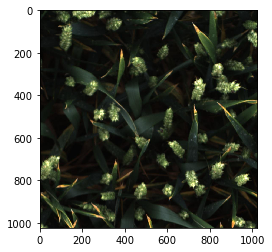

In [16]:
x,y = train_gen.__getitem__(0)
plt.imshow(x[0])

In [ ]:
# im = Image.fromarray(masks[list(masks.keys())[7]])
# plt.imshow(im)

### Let's load the dataset

Let's quickly look at what the images and mask look like (credits : https://www.kaggle.com/devvindan/wheat-detection-eda)

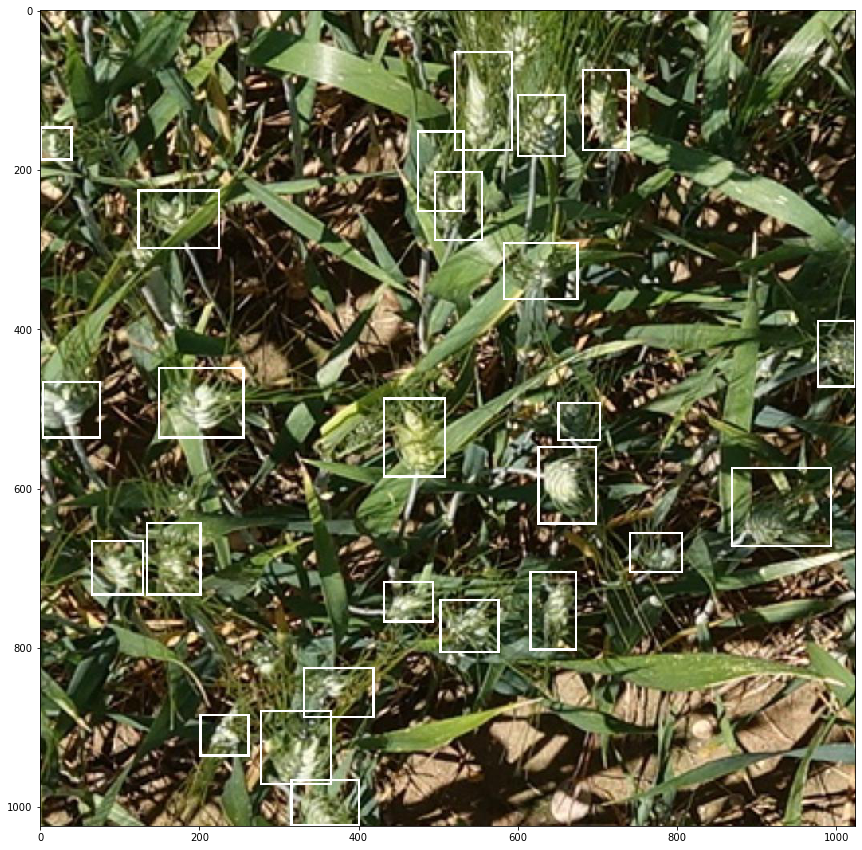

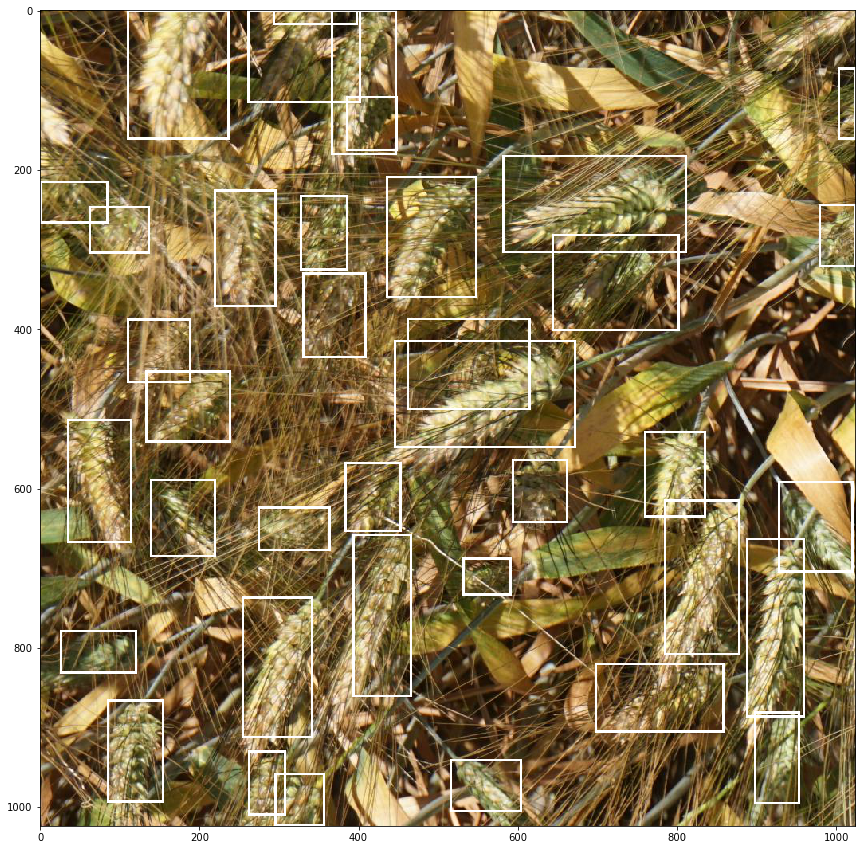

In [17]:
def show_images(images, num=2):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_folder, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in df[df['image_id'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()


unique_images = df['image_id'].unique()
show_images(unique_images)

## Custom Loss and Metric

In [18]:
def multiscale_structural_similarity(y_true, y_pred, max_val=1.0, k1=0.01, k2=0.03, **kwargs):
    """Calculate the multiscale structural similarity (MS-SSIM) between true
    and predicted tensor.
    """
    return K.mean(tf_ssim_multiscale(y_true, y_pred, max_val=max_val, k1=k1, k2=k2, **kwargs))

def normalized_multiscale_structural_similarity(y_true, y_pred, **kwargs):
    """Calculates a normalized multiscale structural similiarity (N-MS-SSIM)

    ```
    0.5*(1 - MS-SSIM(y_true, y_pred)).
    ```

    That is, the N-MS-SSIM is ranged in [0, 1] where
    0 corresponds to a maximal similarity.

    """
    return 0.5*(1.0 - multiscale_structural_similarity(y_true, y_pred, **kwargs))


def custom_loss(y_true, y_pred, max_val=1.0, k1=0.01, k2=0.03, delta=0.5, **kwargs):
    return normalized_multiscale_structural_similarity(y_true, y_pred, max_val, k1, k2) + huber_loss_keras(y_true, y_pred, delta)


In [19]:
#Credits to : https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044

def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred):

    tresholds = [0.5 + (i * 0.05)  for i in range(5)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [20]:
#### Build U-Net model
    
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

p5 = Conv2DTranspose(16, (8, 8), strides=(16,16), padding = 'same') (c5)
u10 = concatenate([p5, c9], axis=3)
c10 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c10)


# instantiating the model in the strategy scope creates the model on the TPU

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=custom_loss, metrics=[competitionMetric2])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 1024, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1024, 1024, 1 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1024, 1024, 1 2320        dropout_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# #data augmentation/ generation
# data_gen_args = dict(#featurewise_center=True,
#                  #featurewise_std_normalization=True,
#                  #rotation_range=10,
#                  #zca_whitening=True,
#                  #width_shift_range=0.2,
#                  #height_shift_range=0.2,
#                  #zoom_range=0.2,
#                  #horizontal_flip=True,
#                  #vertical_flip=True
#                 )
# image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)
# # Provide the same seed and keyword arguments to the fit and flow methods
# #seed = 10
# #image_datagen.fit(X_train, augment=True#, seed=seed)
# #mask_datagen.fit(Y_train, augment=True#, seed=seed)
# image_generator = image_datagen.flow(
#     X_train,
#     batch_size=4,
#     #seed=42
# )
# mask_generator = mask_datagen.flow(
#     Y_train,
#     batch_size=4,
#     #seed=42
# )
# # combine generators into one which yields image and masks
# # train_generator = (pair for pair in zip(image_generator, mask_generator))


In [21]:
# Fit model
earlystop = EarlyStopping(monitor='val_loss',patience=5, verbose=1, restore_best_weights=True)

model.fit(train_gen,
          epochs=EPOCHS, 
          validation_data=valid_gen,
          callbacks=[earlystop],
          max_queue_size=max_queue_size, 
          workers=workers, 
          use_multiprocessing=use_multiprocessing
         )

Epoch 1/25
   2/2908 [..............................] - ETA: 17:40:38 - loss: nan - competitionMetric2: 0.0000e+00   

KeyboardInterrupt: 

In [ ]:
model.save('model.h5')

## Prediction

As `x_gen` is already formatted, we can directly make a prediction

In [ ]:
THRESH = 0.65

preds = model.predict(test_gen)[:, :, :, 0]
masked_preds = preds > THRESH


Here we want to binarize the prediction to get a mask (as the input y_train was also a mask)

* Let's visualise predictions ! 

In [ ]:
n_rows = 3
f, ax = plt.subplots(n_rows, 3, figsize=(14, 10))

for j, idx in enumerate([4,5,6]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = test_gen[idx]
        elif kind == 'pred':
            img = preds[idx]
        elif kind == 'masked_pred':
            masked_pred = preds[idx] > THRESH
            img = masked_pred
        ax[j, k].imshow(img)

plt.tight_layout()

Seems not too bad ! 

### Now the next step is to translate our masked predictions into several bouding boxes

For the moment, I'll assign 1.0 confidence for every box

In [ ]:
def get_params_from_bbox(coords, scaling_factor=1):
    xmin, ymin = coords[1] * scaling_factor, coords[0] * scaling_factor
    w = (coords[3] - coords[1]) * scaling_factor
    h = (coords[2] - coords[0]) * scaling_factor
    
    return xmin, ymin, w, h

In [ ]:
# Allows to extract bounding boxes from binary masks
bboxes = list()

for j in range(masked_preds.shape[0]):
    label_j = label(masked_preds[j, :, :]) 
    props = regionprops(label_j)   # that's were the job is done
    bboxes.append(props)

In [ ]:
# Here we format the bboxes into the required format
output = dict()

for i in range(masked_preds.shape[0]):
    bboxes_processed = [get_params_from_bbox(bb.bbox, scaling_factor=SC_FACTOR) for bb in bboxes[i]]
    formated_boxes = ['1.0 ' + ' '.join(map(str, bb_m)) for bb_m in bboxes_processed]
    
    output[sample_sub["image_id"][i]] = " ".join(formated_boxes)

In [ ]:
sample_sub["PredictionString"] = output.values()

In [ ]:
sample_sub

In [ ]:
sample_sub.to_csv('submission.csv', index=False)

In [ ]:
df = pd.read_csv('kaggle/working/submission.csv')
pre_images = test_images[:,:,:,0]
show_images(pre_images)